# Bayesian Linear Regression

In this example, we are going to perform a simple linear regression problem, but in the Bayesian setting. We specify the model's likelihood as:
$$
y_i = a * x_i + b
$$
where $a$ and $b$ are random variables with the following priors:
$$
\begin{align*}
    p(a) &= \mathcal{N}(a|m_a, v_a) \\
    p(b) &= \mathcal{N}(b|m_b, v_b)
\end{align*}
$$
$x_i$ and $y_i$ are observed values.

In [91]:
using ReactiveMP, GraphPPL, Rocket, Random, Plots, StableRNGs, BenchmarkTools

In [92]:
@model function linear_regression(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 1.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(x[i] * a + b, 1.0)
    end
    
    return a, b, x, y
end

Next step is to define an inference procedure.

In order to test our inference procedure we create a test dataset where observations are corrupted with noise (with known variance).

In [93]:
reala = 0.5
realb = 25

N = 100

rng = StableRNG(1234)

xorig = collect(1:N)

xdata = xorig .+ randn(rng, N)
ydata = realb .+ reala .* xorig .+ randn(rng, N);

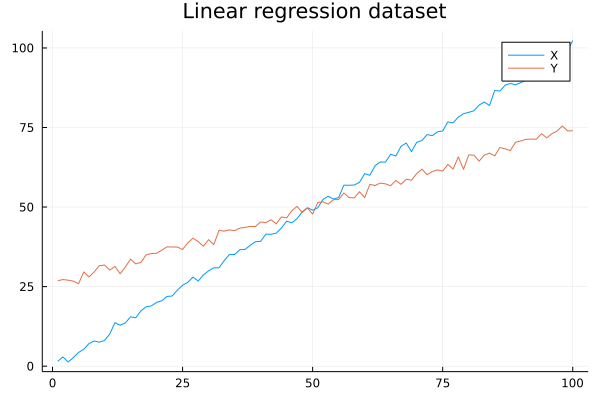

In [94]:
plot(xdata, label = "X", title = "Linear regression dataset")
plot!(ydata, label = "Y")

In [95]:
results = inference(model=Model(linear_regression, length(xdata)), data=(y=ydata, x=xdata), initmessages=(b=NormalMeanVariance(0.0, 100.0),), returnvars=(a = KeepLast(), b = KeepLast()), iterations=20);

In [96]:
using Parameters
@unpack a, b = results.posteriors

Dict{Symbol, Marginal{NormalWeightedMeanPrecision{Float64}}} with 2 entries:
  :a => Marginal(NormalWeightedMeanPrecision{Float64}(xi=170134.00111525942, w=…
  :b => Marginal(NormalWeightedMeanPrecision{Float64}(xi=2444.969667396102, w=9…

In [97]:
println("Real a: ", reala, " | Estimated a: ", mean(a), " | Error: ", abs(mean(a) - reala))
println("Real b: ", realb, " | Estimated b: ", mean(b), " | Error: ", abs(mean(b) - realb))

Real a: 0.5 | Estimated a: 0.5079950235837422 | Error: 0.007995023583742156
Real b: 25 | Estimated b: 24.45212081274467 | Error: 0.5478791872553295


We can see that ReactiveMP.jl estimated real values of linear regression coefficients with high precision. Lets also test the benchmark of the resulting inference procedure.

In [98]:
println("Benchmark for N = ", N, " points in a dataset.")
@benchmark inference(model=Model(linear_regression, length($xdata)), data=(y=$ydata, x=$xdata), initmessages=(b=NormalMeanVariance(0.0, 100.0),), returnvars=(a = KeepLast(), b = KeepLast()), iterations=20)

Benchmark for N = 100 points in a dataset.


BenchmarkTools.Trial: 279 samples with 1 evaluation.
 Range (min … max):  13.154 ms … 39.521 ms  ┊ GC (min … max):  0.00% … 44.56%
 Time  (median):     15.609 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   18.002 ms ±  5.436 ms  ┊ GC (mean ± σ):  10.42% ± 15.46%

     ▃▄█▇                                                      
  ▄▅▆█████▄▆▄▄▄▄▄▄▄▂▃▃▁▃▂▁▂▂▁▁▁▁▁▁▂▂▁▂▂▄▃▄▂▂▁▃▃▃▂▁▂▂▂▂▁▁▁▁▃▁▃ ▃
  13.2 ms         Histogram: frequency by time        35.5 ms <

 Memory estimate: 11.32 MiB, allocs estimate: 248969.